<a href="https://colab.research.google.com/github/maheravi/Deep-Learning/blob/main/PyTorch%20Age%20Prediction%20Using%20Face%20Image/PyTorch_Age_Prediction_Using_Face_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new


utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq utkface-new.zip

replace UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: NA


In [ ]:
!pip install wandb
import wandb

In [43]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np

In [44]:
import wandb

wandb.init(project="AgePrediction", entity="ma_heravi")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
# hyperparameters
latent_size = 10
disc_inp_sz = 224*224
img_size = 224
epochs = 10
batch_size = 32
lr = 0.001
width = height = 224
# wandb.config = {
#   "learning_rate": lr,
#   "epochs": epochs,
#   "batch_size": batch_size
# }

In [46]:
images = []
ages = []

for image_name in os.listdir('crop_part1')[0:9000]:
    part = image_name.split('_')
    ages.append(int(part[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [47]:
images = pd.Series(images, name= 'Images')
ages = pd.Series(ages, name= 'Ages')

df = pd.concat([images, ages], axis= 1)
df.head()

,Images,Ages
0,"[[[56, 47, 30], [61, 52, 35], [69, 57, 43], [7...",53
1,"[[[109, 70, 65], [110, 71, 66], [113, 75, 72],...",10
2,"[[[42, 35, 29], [41, 34, 28], [41, 34, 28], [4...",29
3,"[[[134, 104, 54], [126, 96, 46], [116, 86, 34]...",43
4,"[[[198, 198, 198], [195, 195, 195], [191, 191,...",24


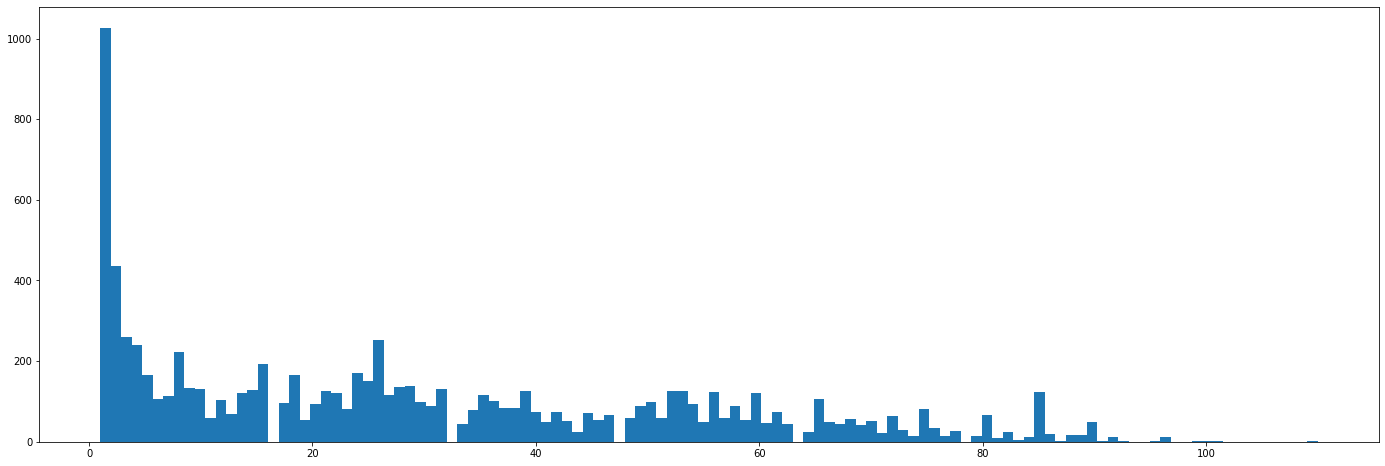

In [48]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 116)
plt.show()

In [49]:
under4 = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4.append(df.iloc[i])

under4 = pd.DataFrame(under4)
under4 = under4.sample(frac= 0.3)

up4 = df[df['Ages'] > 4]

df = pd.concat([under4, up4])

In [50]:
df = df[df['Ages'] < 90]

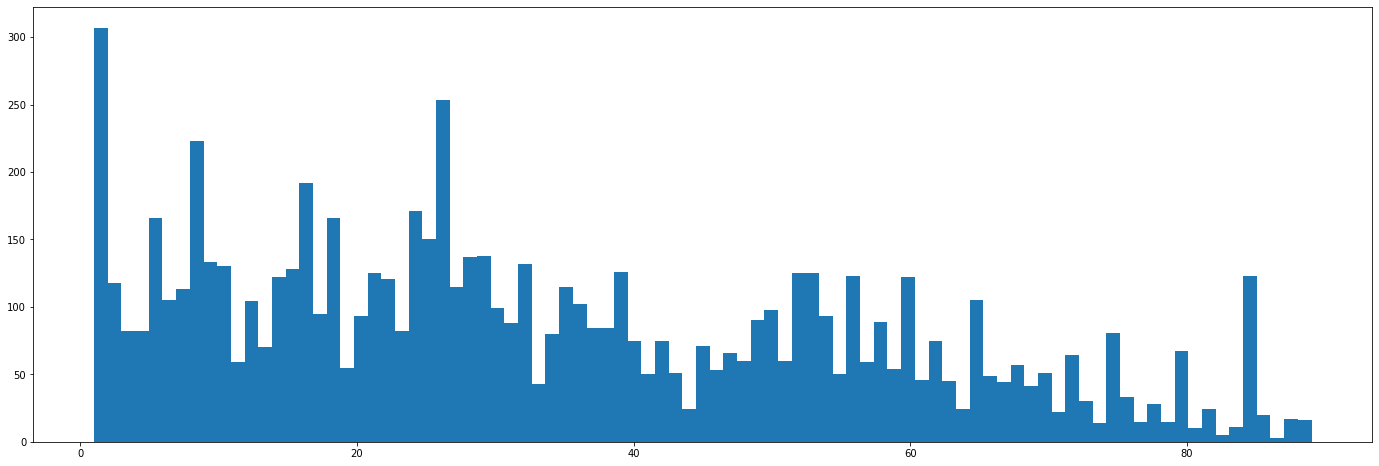

In [51]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 89)
plt.show()

In [52]:
X = []
Y = []

for i in range(len(df)):
    df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

    X.append(df['Images'].iloc[i])
    Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [53]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [54]:
# X_train = X_train.astype(np.float32)

In [55]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_train = torch.permute(X_train, (0, 3, 2, 1))

In [56]:
# from torch.utils.data import TensorDataset

In [57]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        # Normalize your data here
        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [58]:
dataset = MyDataset(X_train, Y_train, transform)
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [59]:
class MyModel(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MyModel, self).__init__()
        self.conv2d = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 32, (3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),            
        )

        self.fc = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(3136, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.ReLU(),
        )
        
    def forward(self, input_t):
      x = self.conv2d(input_t)
      # print(x.shape)
      return self.fc(x)

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MyModel(disc_inp_sz, latent_size).to(device)

model = model.to(device)
model.train(True)

MyModel(
  (conv2d): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): ReLU()
  )
)

In [62]:
 # compile
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = torch.nn.MSELoss()

In [67]:
# train

for epoch in range(1, epochs+1):
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 1- forwarding
        preds = model(images)
        # print(labels)
        # print(preds)
        # 2- backwarding
        loss = loss_function(preds, labels.float())
        loss.backward()
        # 3- Update
        optimizer.step()

        train_loss += loss
    
    total_loss = train_loss / len(train_data_loader)

    print(f"Epoch: {epoch}, Loss: {total_loss}")
    wandb.log({'epochs':  epoch,
              'loss': total_loss,
                              })

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 535.1017456054688
Epoch: 2, Loss: 534.508544921875
Epoch: 3, Loss: 533.529296875
Epoch: 4, Loss: 532.7147827148438
Epoch: 5, Loss: 531.9833374023438
Epoch: 6, Loss: 531.3654174804688
Epoch: 7, Loss: 529.9576416015625
Epoch: 8, Loss: 529.8722534179688
Epoch: 9, Loss: 528.4984130859375
Epoch: 10, Loss: 527.805908203125


In [69]:
# save
torch.save(model.state_dict(), "FaceAgePrediction.pth")